# Back-Test of 3M vol Swap (Start from 2010), group by Sectors
Vol Swap 3M, payoff = RV(3M) - IV(3M)

Rebalance every week (5 trading days).

Trading universe is SP500 on a rolling base, and is grouped into 3 sub-universe: small(<10b), mid(10b~50b), large(>50b)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# Load Data

In [2]:
directory = "h:/test_2005/"

trading_dates = pd.read_csv(directory + "trading_dates.csv", index_col=0)
trading_dates["MarketDate"] = pd.to_datetime(trading_dates["MarketDate"])

data = pd.read_csv(directory+"rolling_universe.csv", index_col=0)["Infocode"]
data.index = pd.to_datetime(data.index)
rolling_universe = {}
for key in data.index:
    rolling_universe[key] = np.array(data[key].split()).astype('int')
    
infocode_dict = pd.read_csv(directory + "infocode_dict.csv", index_col=0)["Ticker"].to_dict()
infocode_to_trid = pd.read_csv(directory + "infocode_to_trid.csv", index_col=0)["ID"].to_dict()
ticker_dict = pd.read_csv(directory + "ticker_dict.csv", index_col=0)["Infocode"].to_dict()
infocode_sector = pd.read_csv(directory + "infocode_sector.csv", index_col=0)["ECONSECT"].to_dict()

In [3]:
def read_stock_data(directory, name):
    stock_data = pd.read_csv(directory + name, index_col=0)
    stock_data.index = pd.to_datetime(stock_data.index)
    stock_data.columns = stock_data.columns.astype("int")
    return stock_data

In [4]:
stock_prices = read_stock_data(directory, 'stock_prices.csv')
stock_iv3m = read_stock_data(directory, 'stock_iv3m.csv')
stock_iv6m = read_stock_data(directory, 'stock_iv6m.csv')
stock_iv12m = read_stock_data(directory, 'stock_iv12m.csv')
stock_iv2m = read_stock_data(directory, 'stock_iv2m.csv')
stock_iv1m = read_stock_data(directory, 'stock_iv1m.csv')
stock_iv1m50delta = read_stock_data(directory, 'stock_iv1m50delta.csv')
stock_iv1m25delta = read_stock_data(directory, 'stock_iv1m25delta.csv')
stock_iv1m75delta = read_stock_data(directory, 'stock_iv1m75delta.csv')
stock_iv2m50delta = read_stock_data(directory, 'stock_iv2m50delta.csv')
stock_iv2m25delta = read_stock_data(directory, 'stock_iv2m25delta.csv')
stock_iv2m75delta = read_stock_data(directory, 'stock_iv2m75delta.csv')

In [5]:
stock_asset_per_equity = read_stock_data(directory, 'stock_asset_per_equity.csv')
stock_asset_per_marketcap = read_stock_data(directory, 'stock_asset_per_marketcap.csv')
stock_eps = read_stock_data(directory, 'stock_eps.csv')
stock_roe = read_stock_data(directory, 'stock_roe.csv')
stock_cps = read_stock_data(directory, 'stock_cps.csv')
stock_cpx_per_marketcap = read_stock_data(directory, 'stock_cpx_per_marketcap.csv')
stock_dps = read_stock_data(directory, 'stock_dps.csv')
stock_marketcap = read_stock_data(directory, 'stock_marketcap.csv')

In [6]:
trading_interval = 5
holding_period = 63

start_date = pd.to_datetime('20100101')
end_date = trading_dates["MarketDate"].iloc[-1]

rebalance_dates = []
valid_dates = trading_dates[(trading_dates["MarketDate"] >= start_date) & (trading_dates["MarketDate"] <= end_date)]
for i in range(0, len(valid_dates), trading_interval):
    rebalance_dates.append(valid_dates["MarketDate"].iloc[i])
    
trading_dates = list(pd.to_datetime(trading_dates["MarketDate"].values))

In [7]:
stock_returns = np.log(stock_prices/stock_prices.shift())

In [8]:
stock_rv1m = pd.rolling_std(stock_returns, 21) * np.sqrt(252)
stock_rv2m = pd.rolling_std(stock_returns, 42) * np.sqrt(252)
stock_rv3m = pd.rolling_std(stock_returns, 63) * np.sqrt(252)
stock_rv6m = pd.rolling_std(stock_returns, 126) * np.sqrt(252)
stock_rv12m = pd.rolling_std(stock_returns, 252) * np.sqrt(252)
stock_rv10d = pd.rolling_std(stock_returns, 10) * np.sqrt(252)

In [9]:
vix = pd.read_csv(directory + 'vix.csv', index_col=0)
vix = pd.Series(vix['vix'].values, index=pd.to_datetime(vix.index))
vix_ma = pd.rolling_mean(vix, 10)

In [10]:
rolling_universe_small = {}
rolling_universe_mid = {}
rolling_universe_large = {}
for date in trading_dates:
    MC = stock_marketcap.loc[date][rolling_universe[date]]
    rolling_universe_small[date] = np.array(MC[MC<10000].index)
    rolling_universe_mid[date] = np.array(MC[(MC<50000) & (MC>10000)].index)
    rolling_universe_large[date] = np.array(MC[MC>50000].index)

In [11]:
infocode_sector[72990]

'Technology'

In [12]:
infocode_sectors = pd.Series(infocode_sector)
sectors = ['Financials', 'Consumer Cyclicals', 'Industrials', 'Technology', 'Healthcare', 'Consumer Non-Cyclicals', 'Energy']
rolling_universe_sectors = {}
for sector in sectors:
    rolling_universe_sectors[sector] = {}
for date in trading_dates:
    universe = infocode_sectors[rolling_universe[date]]
    for sector in sectors:
        if sector != 'Others':
            rolling_universe_sectors[sector][date] = np.array(universe[universe == sector].index)
        else:
            rolling_universe_sectors[sector][date] = np.array(universe[(universe == 'Utilities') | (universe == 'Basic Materials') | (universe == 'Telecommunications Services') | (universe == 'Others')].index)

# Back Test Result

In [13]:
def backtest3m(score):
    daily_pnl = pd.Series(np.zeros(len(trading_dates)), index=trading_dates)
    for i in range(len(trading_dates)):
        date = trading_dates[i]
        #print date
        if (date in rebalance_dates) & (i + holding_period < len(trading_dates)):
            z = score.loc[date][rolling_universe[date]].dropna()
            z = (z-z.mean()) / z.std()
            z.sort(ascending=False)
            long_short = np.append(z.index[ : 1*len(z)/10], z.index[-(1*len(z)/10) : ])
            for infocode in long_short:
                if not np.isnan(stock_iv3m[infocode][date]):
                    daily_pnl[trading_dates[i+holding_period]] += (100 / len(long_short)) * np.sign(z[infocode]) * (stock_rv3m[infocode][trading_dates[i+holding_period]] - stock_iv3m[infocode][date])
    return daily_pnl

def backtest3m_sectors(score, sector):
    daily_pnl = pd.Series(np.zeros(len(trading_dates)), index=trading_dates)
    for i in range(len(trading_dates)):
        date = trading_dates[i]
        #print date
        if (date in rebalance_dates) & (i + holding_period < len(trading_dates)):
            z = score.loc[date][rolling_universe_sectors[sector][date]].dropna()
            z = (z-z.mean()) / z.std()
            z.sort(ascending=False)
            long_short = np.append(z.index[ : 1*len(z)/10], z.index[-(1*len(z)/10) : ])
            for infocode in long_short:
                if not np.isnan(stock_iv3m[infocode][date]):
                    daily_pnl[trading_dates[i+holding_period]] += (100 / len(long_short)) * np.sign(z[infocode]) * (stock_rv3m[infocode][trading_dates[i+holding_period]] - stock_iv3m[infocode][date])
    return daily_pnl


In [14]:
def sharpe_ratio(pnl):
    return pnl[pnl != 0].mean() / pnl[pnl != 0].std() * np.sqrt(12/3)

def pnl_mean(pnl):
    return pnl[pnl != 0].mean()

def pnl_std(pnl):
    return pnl[pnl != 0].std()

def hit_rate(pnl):
    return float(len(pnl[pnl > 0])) / len(pnl[pnl != 0])

def pnl_min(pnl):
    return pnl[pnl != 0].min()

def pnl_25perc(pnl):
    return pnl[pnl != 0].quantile(0.25)

def pnl_median(pnl):
    return pnl[pnl != 0].median()

def pnl_75perc(pnl):
    return pnl[pnl != 0].quantile(0.75)

def pnl_max(pnl):
    return pnl[pnl != 0].max()

def pnl_days(pnl):
    return len(pnl[pnl != 0])

In [15]:
def report_table(pnls, sectors):
    result = pd.DataFrame(index = sectors, columns=['Sharpe Ratio', 'PnL Mean', 'PnL Std', 'Hit Rate', 'PnL Min', 'PnL 25%Perc', 'PnL Median', 'PnL 75%Perc', 'PnL Max'])
    for sector in sectors:
        result.loc[sector]['Sharpe Ratio'] = sharpe_ratio(pnls[sector])
        result.loc[sector]['PnL Mean'] = pnl_mean(pnls[sector])
        result.loc[sector]['PnL Std'] = pnl_std(pnls[sector])
        result.loc[sector]['Hit Rate'] = hit_rate(pnls[sector])
        result.loc[sector]['PnL Min'] = pnl_min(pnls[sector])
        result.loc[sector]['PnL 25%Perc'] = pnl_25perc(pnls[sector])
        result.loc[sector]['PnL Median'] = pnl_median(pnls[sector])
        result.loc[sector]['PnL 75%Perc'] = pnl_75perc(pnls[sector])
        result.loc[sector]['PnL Max'] = pnl_max(pnls[sector])
    return result

In [16]:
def annual_pnl_mean(pnls, sectors):
    years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
    result = pd.DataFrame(index = sectors, columns=years)
    for sector in sectors:
        for year in years:
            result.loc[sector][year] = pnl_mean(pnls[sector][pd.to_datetime(year+'0101') : pd.to_datetime(year+'1231')])
    result.fillna(0, inplace=True)
    return result

In [17]:
def annual_trade_days(pnls, labels):
    years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
    result = pd.DataFrame(index = sectors, columns=years)
    for i in range(len(pnls)):
        for year in years:
            result.loc[labels[i]][year] = pnl_days(pnls[i][pd.to_datetime(year+'0101') : pd.to_datetime(year+'1231')])
    result.fillna(0, inplace=True)
    return result

In [18]:
def annual_stock_numbers(labels=['small(<10B)','mid(10B~50B)','large(>50B)']):
    years = ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
    result = pd.DataFrame(index = labels, columns=years)
    for year in years:
        date = np.array(trading_dates)[np.array(trading_dates) > pd.to_datetime(year+'0101')][0]
        total = float(len(rolling_universe[date]))
        result.loc['small(<10B)'][year] = len(rolling_universe_small[date]) / total
        result.loc['mid(10B~50B)'][year] = len(rolling_universe_mid[date]) / total
        result.loc['large(>50B)'][year] = len(rolling_universe_large[date]) / total
    return result

## RV-IV

In [19]:
pnls = {}
for sector in sectors:
    pnls[sector] = backtest3m_sectors(stock_rv3m - stock_iv3m, sector)

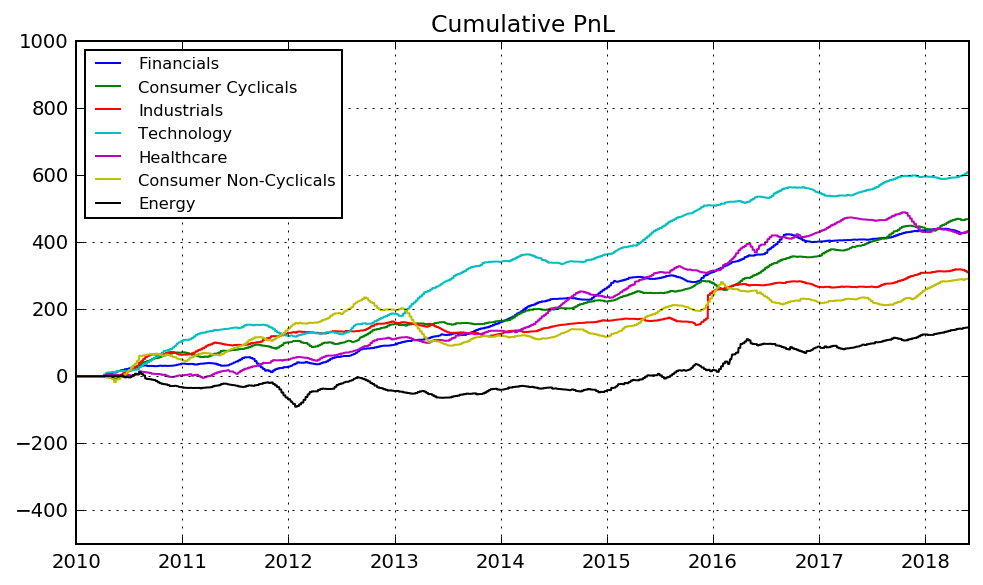

In [20]:
plt.figure(figsize=(8, 4.5))
for sector in sectors:
    plt.plot(pnls[sector].cumsum(), label=sector)
plt.xlim(pd.to_datetime('20100101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-500, 1000)
plt.savefig('h:/rv-iv.png')
plt.show()

In [21]:
performance = report_table(pnls, sectors)
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
Financials,0.962269,1.04992,2.18217,0.734793,-7.32618,-0.0634262,0.900497,2.27406,9.12934
Consumer Cyclicals,1.08203,1.1411,2.10918,0.703163,-4.93416,-0.203587,1.20738,2.56013,7.485
Industrials,0.387051,0.754668,3.89957,0.647202,-5.72441,-0.449535,0.46573,1.67913,70.2063
Technology,1.24388,1.48303,2.38452,0.742092,-5.43555,-0.0266039,1.3746,3.17111,8.53966
Healthcare,0.709336,1.05375,2.97109,0.654501,-9.55113,-0.755378,0.946772,2.9512,10.2423
Consumer Non-Cyclicals,0.397982,0.708349,3.5597,0.605839,-10.2429,-1.26043,0.764721,2.72355,15.2843
Energy,0.224076,0.354029,3.15989,0.557178,-9.188,-1.30091,0.364686,1.98122,14.2445


In [22]:
pnl_mean_yearly = annual_pnl_mean(pnls, sectors)
pnl_mean_yearly

,2010,2011,2012,2013,2014,2015,2016,2017
Financials,0.985427,-0.171088,1.317507,1.327970,2.008335,0.982583,1.815918,0.666576
Consumer Cyclicals,1.876752,0.590881,1.099200,0.177644,1.159540,1.061562,1.626215,1.708530
Industrials,1.683161,1.278619,0.616058,-0.675079,0.799667,1.703300,0.276607,0.841910
Technology,2.771225,0.291451,1.322242,3.101301,0.444189,2.875506,0.766590,0.948690
Healthcare,0.065240,0.924857,1.242575,0.478835,1.998389,1.562936,2.292053,0.020067
Consumer Non-Cyclicals,1.291251,1.835972,1.094043,-1.532406,-0.062733,2.462961,-0.449681,0.666080
Energy,-0.869517,-0.698169,0.479321,0.084595,-0.079928,1.234566,1.397112,0.725369


## Vol Skew

In [23]:
pnls = {}
for sector in sectors:
    pnls[sector] = backtest3m_sectors((stock_iv2m75delta - stock_iv2m25delta) / stock_iv1m50delta, sector)

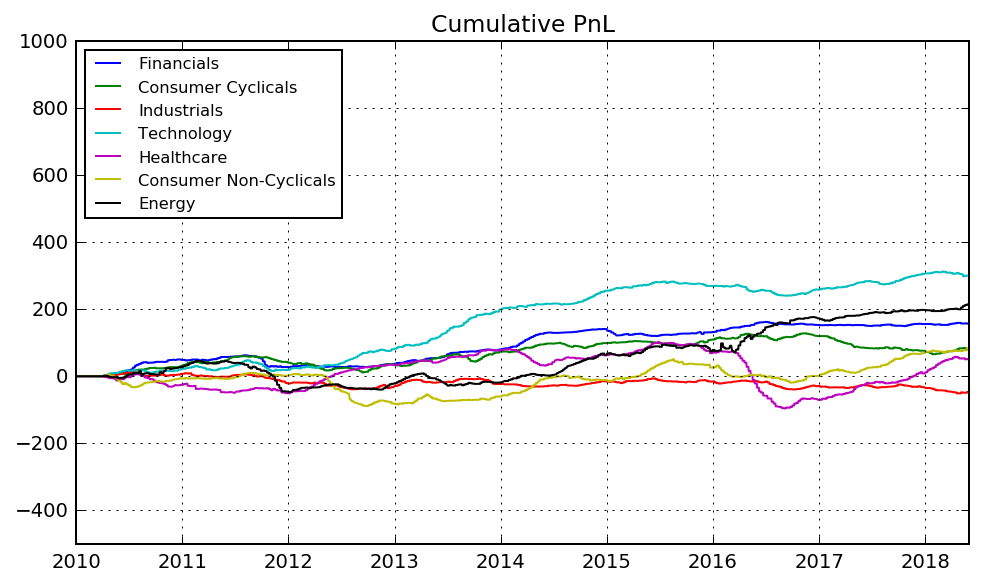

In [24]:
plt.figure(figsize=(8, 4.5))
for sector in sectors:
    plt.plot(pnls[sector].cumsum(), label=sector)
plt.xlim(pd.to_datetime('20100101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-500, 1000)
plt.savefig('h:/rv-iv.png')
plt.show()

In [25]:
performance = report_table(pnls, sectors)
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
Financials,0.487902,0.394313,1.61636,0.636591,-10.6545,-0.342679,0.450707,1.24487,5.77017
Consumer Cyclicals,0.205772,0.199527,1.9393,0.555276,-6.35167,-1.10115,0.299192,1.54365,5.80038
Industrials,-0.147624,-0.118013,1.59882,0.48995,-5.57655,-1.0507,-0.023955,0.914571,4.56441
Technology,0.725775,0.754124,2.07812,0.645729,-7.47116,-0.606377,0.818335,2.13798,6.86974
Healthcare,0.0809308,0.128697,3.18041,0.585427,-14.9565,-1.05565,0.63751,2.00249,7.59671
Consumer Non-Cyclicals,0.152919,0.210286,2.7503,0.575377,-17.5325,-0.98266,0.486829,1.81831,8.48978
Energy,0.323102,0.539303,3.33829,0.623116,-15.2151,-0.912731,0.609655,2.02699,21.3015


In [26]:
pnl_mean_yearly = annual_pnl_mean(pnls, sectors)
pnl_mean_yearly

,2010,2011,2012,2013,2014,2015,2016,2017
Financials,1.323730,-0.468989,0.230431,0.890056,1.320291,-0.173028,0.421181,0.054687
Consumer Cyclicals,0.843818,0.188134,-0.111015,0.798176,0.553227,0.208651,0.201954,-0.866927
Industrials,0.193643,-0.609781,-0.152466,0.122487,0.170763,0.001872,-0.278821,-0.069554
Technology,0.597294,-0.062935,1.344157,2.435576,1.217380,0.274905,-0.215971,0.949193
Healthcare,-0.689413,-0.534775,1.782603,0.933104,-0.327464,0.173411,-2.833603,1.570200
Consumer Non-Cyclicals,-0.172252,0.182786,-1.811799,0.465469,1.074517,0.719176,-0.496195,1.360229
Energy,0.752408,-1.560921,0.555665,0.050516,1.786188,0.288647,1.886005,0.508277


## Term Structure

In [27]:
pnls = {}
for sector in sectors:
    pnls[sector] = backtest3m_sectors(- stock_iv3m + stock_iv6m, sector)

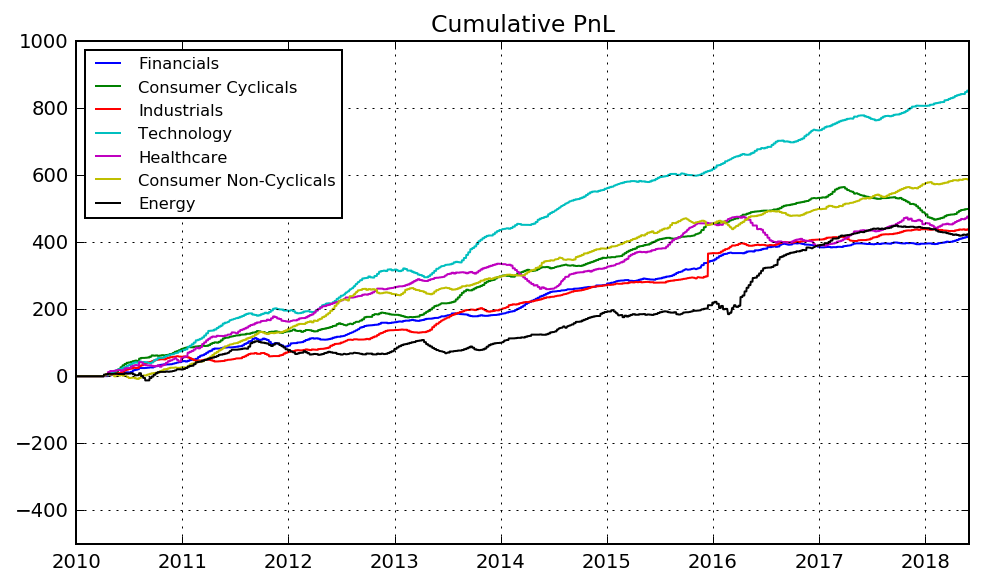

In [28]:
plt.figure(figsize=(8, 4.5))
for sector in sectors:
    plt.plot(pnls[sector].cumsum(), label=sector)
plt.xlim(pd.to_datetime('20100101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-500, 1000)
plt.savefig('h:/rv-iv.png')
plt.show()

In [29]:
performance = report_table(pnls, sectors)
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
Financials,1.16591,1.01447,1.74023,0.739659,-6.3119,-0.0516535,0.933897,2.06721,7.70801
Consumer Cyclicals,1.01248,1.21524,2.40053,0.744526,-8.5966,-0.0654066,1.27171,2.62542,8.33248
Industrials,0.578819,1.06764,3.68904,0.746959,-4.64253,-0.01067,0.947136,1.89342,67.8452
Technology,1.67064,2.07527,2.48441,0.793187,-4.57725,0.417224,2.17194,3.77234,9.27719
Healthcare,0.70907,1.16016,3.27235,0.703163,-10.8344,-0.432572,1.59439,3.22286,11.1679
Consumer Non-Cyclicals,1.0675,1.43015,2.67945,0.737226,-10.7512,-0.0415295,1.72617,3.07863,12.8631
Energy,0.586595,1.03147,3.51681,0.681265,-15.7849,-0.610512,1.07295,2.4006,25.8623


In [30]:
pnl_mean_yearly = annual_pnl_mean(pnls, sectors)
pnl_mean_yearly

,2010,2011,2012,2013,2014,2015,2016,2017
Financials,1.161248,0.928729,1.393802,0.482271,1.747712,1.430328,0.820426,0.179630
Consumer Cyclicals,2.142116,1.031281,0.985611,2.291850,1.107399,1.987743,1.557856,-0.858646
Industrials,1.523850,0.284372,1.310775,1.221805,1.447461,1.887635,0.809471,0.613513
Technology,1.990720,2.344338,2.466256,2.364015,2.462846,1.154316,2.307533,1.469119
Healthcare,1.418453,2.136444,2.065428,1.388766,-0.238441,2.585188,-1.311658,1.278873
Consumer Non-Cyclicals,0.699090,2.252873,2.065892,1.059966,1.664151,1.476487,0.864381,1.474722
Energy,0.522903,1.147099,0.065108,0.361139,1.839298,0.550155,3.419351,1.040165


## Cash Bollinger

In [31]:
pnls = {}
for sector in sectors:
    pnls[sector] = backtest3m_sectors(np.abs((stock_prices - pd.rolling_mean(stock_prices, 378)) / pd.rolling_std(stock_prices, 378)), sector)

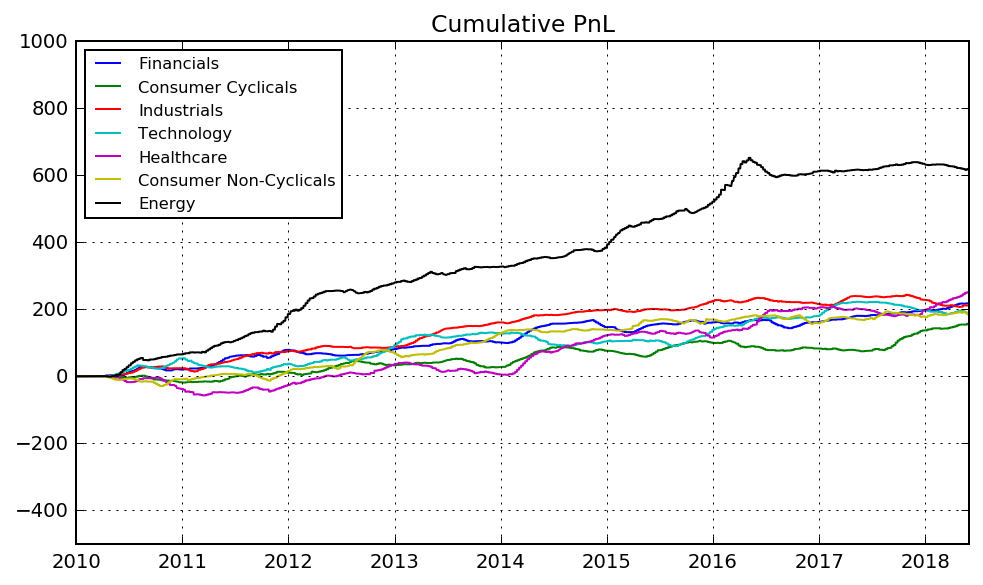

In [32]:
plt.figure(figsize=(8, 4.5))
for sector in sectors:
    plt.plot(pnls[sector].cumsum(), label=sector)
plt.xlim(pd.to_datetime('20100101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-500, 1000)
plt.savefig('h:/rv-iv.png')
plt.show()

In [33]:
performance = report_table(pnls, sectors)
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
Financials,0.644851,0.529873,1.6434,0.6618,-5.68997,-0.271103,0.557826,1.44113,5.16142
Consumer Cyclicals,0.437015,0.381034,1.7438,0.559611,-5.25166,-0.818921,0.212394,1.62219,7.11919
Industrials,0.709275,0.514013,1.4494,0.666667,-4.08089,-0.357239,0.463519,1.4786,4.87795
Technology,0.44445,0.454138,2.0436,0.571776,-6.18616,-0.914075,0.404298,1.68789,7.39475
Healthcare,0.493492,0.609784,2.4713,0.579075,-7.02621,-1.00711,0.509804,2.11449,11.2989
Consumer Non-Cyclicals,0.415818,0.449631,2.16264,0.591241,-5.63575,-0.864846,0.460955,1.5844,10.2677
Energy,0.948374,1.50546,3.17482,0.712895,-7.30715,-0.250168,1.12761,2.86234,15.0453


In [34]:
pnl_mean_yearly = annual_pnl_mean(pnls, sectors)
pnl_mean_yearly

,2010,2011,2012,2013,2014,2015,2016,2017
Financials,0.514639,1.158134,0.053148,0.391626,0.914606,0.278776,0.021696,0.681424
Consumer Cyclicals,-0.485164,0.563269,0.442241,-0.106435,0.982520,0.461335,-0.342103,1.080875
Industrials,0.628744,0.995813,0.268877,1.458045,0.737364,0.527545,-0.183618,0.254615
Technology,1.374388,-0.297724,1.136522,0.682354,-0.486007,0.687631,0.828490,0.333344
Healthcare,-1.005696,0.235720,1.252463,-0.625215,2.327147,-0.116340,1.776740,-0.143358
Consumer Non-Cyclicals,-0.241053,0.487096,1.038417,1.211852,0.204521,0.599725,-0.222278,0.410665
Energy,1.719108,2.356734,1.888708,0.943982,1.128994,2.699898,1.819987,0.444921


## Cash RSI

In [35]:
stock_delta1 = stock_prices - stock_prices.shift(1)
stock_gain = stock_delta1[stock_delta1>0]
stock_loss = np.abs(stock_delta1[stock_delta1<0])

def stock_rsi(N):
    return 100 * 1 / (1 + pd.rolling_mean(stock_loss, N, min_periods=0) / pd.rolling_mean(stock_gain, N, min_periods=0))

In [36]:
pnls = {}
for sector in sectors:
    pnls[sector] = backtest3m_sectors(-stock_rsi(63), sector)

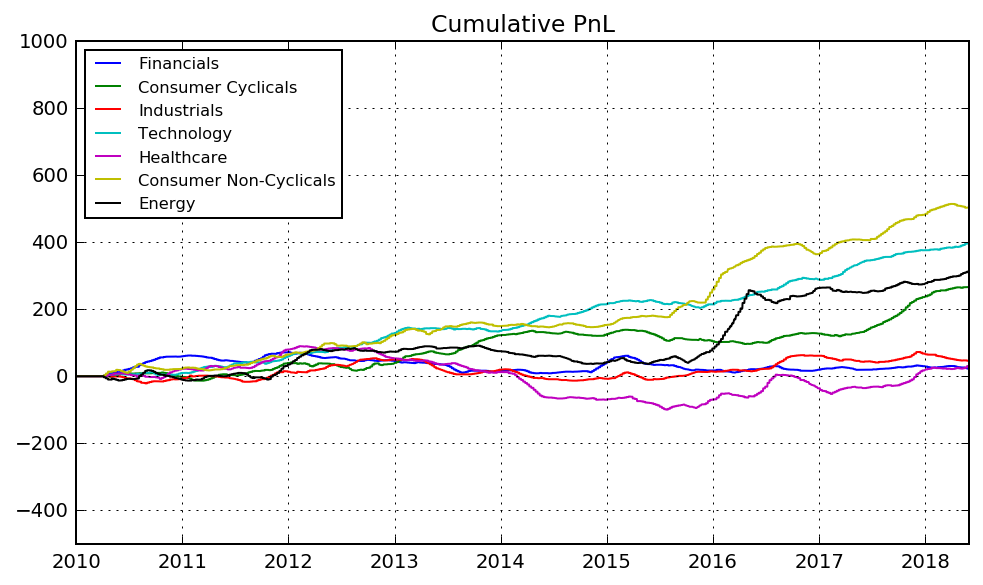

In [37]:
plt.figure(figsize=(8, 4.5))
for sector in sectors:
    plt.plot(pnls[sector].cumsum(), label=sector)
plt.xlim(pd.to_datetime('20100101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-500, 1000)
plt.savefig('h:/rv-iv.png')
plt.show()

In [38]:
performance = report_table(pnls, sectors)
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
Financials,0.0739714,0.0552578,1.49403,0.486618,-4.26907,-0.819069,-0.0535913,0.829346,4.92152
Consumer Cyclicals,0.674429,0.647469,1.92005,0.608273,-4.46677,-0.599934,0.479502,1.8841,7.47461
Industrials,0.135093,0.112157,1.66044,0.513382,-4.5879,-0.976983,0.0412604,0.951416,5.16492
Technology,1.16376,0.966194,1.66047,0.717762,-3.41047,-0.191713,0.885524,2.12285,6.2743
Healthcare,0.0579657,0.0737431,2.54437,0.484185,-6.3882,-1.39087,-0.104833,1.32498,11.3134
Consumer Non-Cyclicals,0.937492,1.22545,2.61432,0.676399,-6.22407,-0.409856,0.797553,2.64364,12.7669
Energy,0.49503,0.760033,3.07065,0.557178,-6.33594,-1.0608,0.337439,1.83555,16.3277


In [39]:
pnl_mean_yearly = annual_pnl_mean(pnls, sectors)
pnl_mean_yearly

,2010,2011,2012,2013,2014,2015,2016,2017
Financials,1.560252,0.248560,-0.532693,-0.599286,0.454469,-0.406984,0.039258,0.213407
Consumer Cyclicals,-0.061040,0.820322,0.009007,1.647494,0.028979,-0.381026,0.460587,2.177322
Industrials,-0.186858,0.397674,0.726718,-0.598124,-0.540736,0.415758,0.948849,0.128458
Technology,0.251552,0.993625,1.378672,0.118564,1.591529,-0.001057,1.488936,1.741688
Healthcare,0.577514,1.135043,-0.533665,-0.817290,-1.651538,0.014444,0.669584,1.067107
Consumer Non-Cyclicals,0.592729,0.837006,1.170303,0.519003,0.065518,2.081471,2.111304,2.346913
Energy,-0.266103,0.885562,0.756902,0.035565,-0.672061,0.816973,3.610639,0.235140


## CPX/MC

In [40]:
pnls = {}
for sector in sectors:
    pnls[sector] = backtest3m_sectors(stock_cpx_per_marketcap, sector)

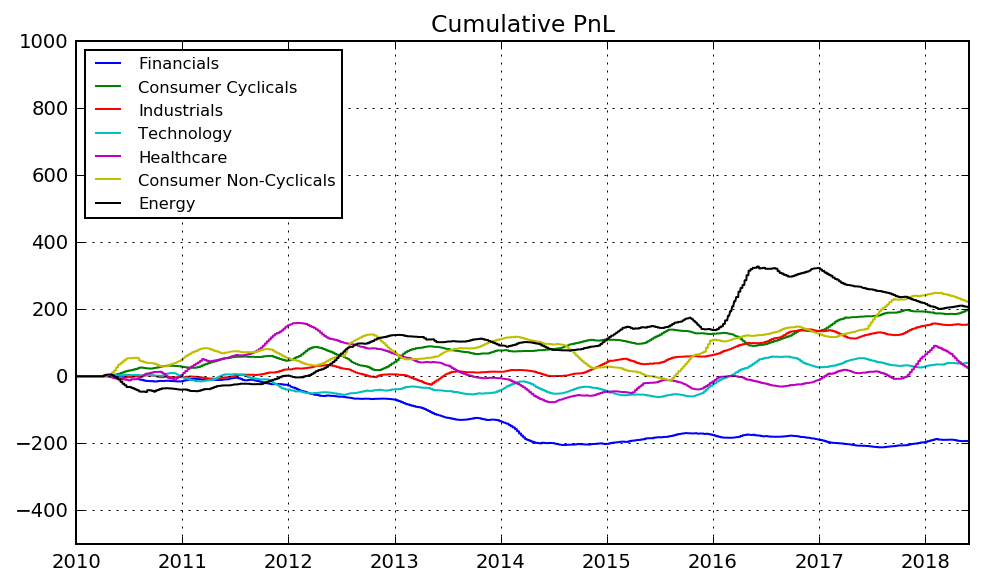

In [41]:
plt.figure(figsize=(8, 4.5))
for sector in sectors:
    plt.plot(pnls[sector].cumsum(), label=sector)
plt.xlim(pd.to_datetime('20100101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-500, 1000)
plt.savefig('h:/rv-iv.png')
plt.show()

In [42]:
performance = report_table(pnls, sectors)
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
Financials,-0.663388,-0.471659,1.42197,0.386861,-10.1473,-1.16286,-0.337925,0.435711,2.51903
Consumer Cyclicals,0.50317,0.484067,1.92407,0.603406,-5.12778,-0.662755,0.374188,1.59761,6.69062
Industrials,0.478774,0.376541,1.57294,0.600973,-3.17894,-0.671847,0.393273,1.31124,4.81194
Technology,0.10639,0.0981908,1.84587,0.489051,-4.77885,-1.12028,-0.0731206,1.16604,5.89326
Healthcare,0.041485,0.0605069,2.91705,0.440389,-7.02496,-1.93065,-0.389553,1.67348,9.0895
Consumer Non-Cyclicals,0.335132,0.540191,3.22375,0.574209,-6.9636,-1.32868,0.428298,1.96333,14.6205
Energy,0.300442,0.503837,3.35396,0.542579,-7.21374,-1.36437,0.27323,1.81531,16.0169


In [43]:
pnl_mean_yearly = annual_pnl_mean(pnls, sectors)
pnl_mean_yearly

,2010,2011,2012,2013,2014,2015,2016,2017
Financials,-0.403852,-0.241866,-0.850110,-1.284590,-1.366153,0.531182,-0.269710,-0.167624
Consumer Cyclicals,0.743173,0.373262,-0.090680,0.685667,0.653315,0.337696,0.171455,1.153948
Industrials,-0.076286,0.460437,-0.302925,0.149551,0.524651,0.479176,1.419770,0.314437
Technology,-0.026867,-0.763115,0.023101,-0.065551,-0.013499,0.359814,1.015134,0.027690
Healthcare,0.102341,2.910480,-1.728499,-1.434549,-0.813706,0.602654,0.090012,1.398776
Consumer Non-Cyclicals,1.303814,0.082347,0.340784,0.789351,-1.655294,1.573881,0.385229,2.287332
Energy,-1.061188,0.815068,2.432188,-0.620842,0.292595,0.622170,3.695604,-2.077998


## DPS

In [44]:
pnls = {}
for sector in sectors:
    pnls[sector] = backtest3m_sectors(stock_dps, sector)

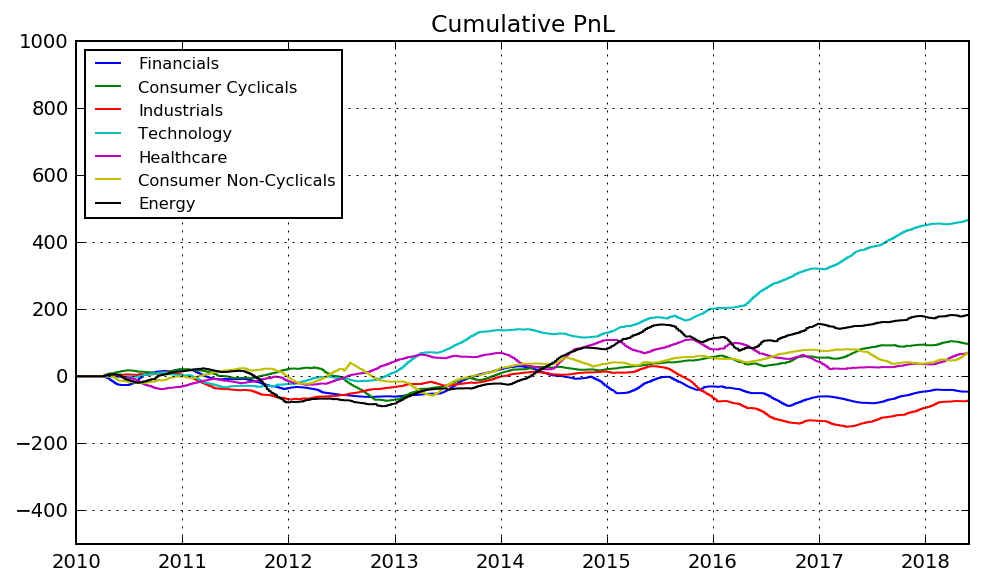

In [45]:
plt.figure(figsize=(8, 4.5))
for sector in sectors:
    plt.plot(pnls[sector].cumsum(), label=sector)
plt.xlim(pd.to_datetime('20100101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-500, 1000)
plt.savefig('h:/rv-iv.png')
plt.show()

In [46]:
performance = report_table(pnls, sectors)
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
Financials,-0.113629,-0.111982,1.97101,0.474453,-5.55164,-1.28681,-0.116215,1.16236,8.52048
Consumer Cyclicals,0.277648,0.234539,1.68948,0.613139,-6.34192,-0.625979,0.448739,1.27658,3.67421
Industrials,-0.203313,-0.177616,1.74722,0.542579,-6.11157,-0.963577,0.206898,0.960955,3.40382
Technology,1.18993,1.13479,1.90732,0.720195,-3.66078,-0.199132,0.909667,2.61743,6.34333
Healthcare,0.160159,0.170231,2.12578,0.545012,-5.45447,-1.06146,0.349931,1.60566,7.30369
Consumer Non-Cyclicals,0.157149,0.169495,2.15714,0.579075,-5.59325,-0.936707,0.339316,1.38562,8.65681
Energy,0.363694,0.444696,2.44545,0.656934,-8.70325,-0.768139,0.608322,1.932,6.53552


In [47]:
pnl_mean_yearly = annual_pnl_mean(pnls, sectors)
pnl_mean_yearly

,2010,2011,2012,2013,2014,2015,2016,2017
Financials,0.515010,-1.078580,-0.510162,1.625059,-0.959620,-0.056001,-0.603236,0.295580
Consumer Cyclicals,0.555762,0.008378,-1.825758,1.566386,0.232322,0.732683,-0.042466,0.779659
Industrials,0.099959,-1.431148,0.746870,0.611571,0.304822,-1.545453,-1.368013,0.756207
Technology,0.100632,-0.531440,0.718773,2.498656,-0.176283,1.435473,2.375071,2.588789
Healthcare,-0.802118,0.299620,1.202960,0.484563,0.764344,-0.536364,-0.732982,-0.144918
Consumer Non-Cyclicals,-0.002681,-0.086365,-0.236077,0.792255,0.265114,0.338376,0.474541,-0.793679
Energy,0.379627,-1.813153,-0.067099,1.189987,2.050140,0.651840,0.853057,0.441944
